- WGAN-gp
- ref: https://keras.io/examples/generative/wgan_gp/

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import os
import gc
import tqdm
import random
import glob

import warnings
warnings.filterwarnings('ignore')

SEED = 42
np.random.seed(SEED)
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers, callbacks, layers, losses
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Input, Reshape, Conv2D, Conv2DTranspose, Flatten
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow_addons as tfa

tf.random.set_seed(SEED)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)
        
def mish(x):
    return x*tf.math.tanh(tf.math.softplus(x))

def leakyrelu(x, factor=0.2):
    return tf.maximum(x, factor*x)

In [3]:
def ConvBlock(n, kernel_size=3, strides=2, bn=True, padding='same'):
    def f(x):
        x = Conv2D(n, kernel_size=kernel_size, strides=strides, padding=padding)(x)
        x = Activation(leakyrelu)(x)       
        if bn:
            x = BatchNormalization(momentum=0.8)(x)
        return x
    return f

def deConvBlock(n, kernel_size=3, strides=2, bn=True, padding='same'):
    def f(x):
        x = Conv2DTranspose(n, kernel_size=kernel_size, strides=strides, padding=padding)(x)
        x = Activation('relu')(x)       
        if bn:
            x = BatchNormalization(momentum=0.8)(x)
        return x
    return f

In [4]:
class WGAN(keras.Model):
    def __init__(self, x_dim, z_dim, gp_weight=10, n_disc=4): # dim: tuple
        super(WGAN, self).__init__()
        self.x_dim = x_dim
        self.z_dim = z_dim
        self.gp_weight = gp_weight
        self.n_disc = n_disc

        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()
        
    def compile(self, g_optim, d_optim, g_loss_fn, d_loss_fn):
        super(WGAN, self).compile()
        self.g_optim = g_optim
        self.d_optim = d_optim
        self.g_loss_fn = g_loss_fn
        self.d_loss_fn = d_loss_fn
        
    def build_generator(self): 
        inputs = Input(shape = self.z_dim)
        
        x = Dense(128*7*7, activation='relu')(inputs)
        x = Reshape((7, 7, 128))(x) # 7, ,7 128
        x = BatchNormalization(momentum=0.8)(x)
        x = deConvBlock(64)(x) # 14, 14, 64
        x = deConvBlock(32)(x) # 28, 28, 32
        
        outputs = Conv2D(1, kernel_size=3, strides=1, activation='tanh', padding='same')(x) # 28, 28, 1
        return Model(inputs, outputs, name='generator')

    def build_discriminator(self):
        inputs = Input(shape = self.x_dim)
        
        x = ConvBlock(16)(inputs)
        x = ConvBlock(32)(x)
        x = ConvBlock(64)(x)
        x = Flatten()(x)
        
        outputs = Dense(1)(x)
        return Model(inputs, outputs, name='discriminator')
    
    def gradient_penalty(self, batch_size, real, fake):
        # Interpolate
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake - real
        interpolated = real + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator(interpolated, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calculate the norm of the gradients.
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp
    
    def train_step(self, x):
        batch_size = tf.shape(x)[0]

        # discriminator
        for _ in range(self.n_disc):
            noise = tf.random.normal((batch_size, self.z_dim))
            
            with tf.GradientTape() as tape:
                fake = self.generator(noise)
                fake_logit = self.discriminator(fake)
                real_logit = self.discriminator(x)
                
                d_loss = self.d_loss_fn(real_logit, fake_logit)
                gp = self.gradient_penalty(batch_size, x, fake)
                d_loss += self.gp_weight * gp

            grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
            self.d_optim.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # generator
        noise = tf.random.normal((batch_size, self.z_dim))
        with tf.GradientTape() as tape:
            fake = self.generator(noise)
            fake_logit = self.discriminator(fake)

            g_loss = self.g_loss_fn(fake_logit)
            
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optim.apply_gradients(zip(grads, self.generator.trainable_weights))

        return {'d_loss': d_loss, 'g_loss': g_loss}

In [5]:
# real: 1, fake: -1
def discriminator_loss(real, fake):
    real_loss = tf.reduce_mean(real)
    fake_loss = tf.reduce_mean(fake)
    return fake_loss - real_loss

def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)

class PlotCallback(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
            r, c = 2, 5
            noise = np.random.normal(0, 1, (r*c, 100))
            imgs = self.model.generator.predict(noise)*0.5 +0.5
            imgs = imgs.reshape(r*c, 28, 28)
            fig, axs = plt.subplots(r, c)
            n = 0
            for i in range(r):
                for j in range(c):
                    axs[i,j].imshow(imgs[n], cmap='gray')
                    axs[i,j].axis('off')
                    n += 1
            plt.show()
            plt.close()

In [6]:
# prepare data
from tensorflow.keras.datasets import mnist
(train_X, train_y), (_, _) = mnist.load_data()
train_X = (train_X - 127.5)/127.5
train_X = np.expand_dims(train_X, -1)


In [7]:
shape = train_X.shape[1:]
gan = WGAN(shape, 100)

In [8]:
gan.compile(
    optimizers.Adam(2e-4, 0.5), 
    optimizers.Adam(2e-4, 0.5), 
    generator_loss,
    discriminator_loss
         )

Epoch 1/101
469/469 [==============================] - ETA: 0s - d_loss: -58.2856 - g_loss: 40.8391

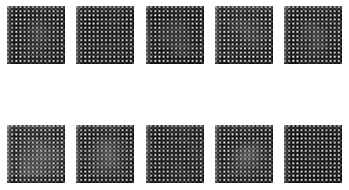

469/469 [==============================] - 34s 73ms/step - d_loss: -58.3811 - g_loss: 40.8423
Epoch 2/101
469/469 [==============================] - 34s 72ms/step - d_loss: -196.9931 - g_loss: 163.6856
Epoch 3/101
469/469 [==============================] - 34s 72ms/step - d_loss: -104.6113 - g_loss: 113.2959
Epoch 4/101
469/469 [==============================] - 34s 73ms/step - d_loss: -67.5331 - g_loss: -42.1076
Epoch 5/101
469/469 [==============================] - 34s 73ms/step - d_loss: -51.7804 - g_loss: -106.1616
Epoch 6/101
469/469 [==============================] - 34s 73ms/step - d_loss: -45.3271 - g_loss: -167.2352
Epoch 7/101
469/469 [==============================] - 34s 72ms/step - d_loss: -23.2645 - g_loss: -243.6521
Epoch 8/101
469/469 [==============================] - 34s 72ms/step - d_loss: -27.0996 - g_loss: -286.1539
Epoch 9/101
469/469 [==============================] - 34s 72ms/step - d_loss: -19.8848 - g_loss: -300.0434
Epoch 10/101
469/469 [=====================

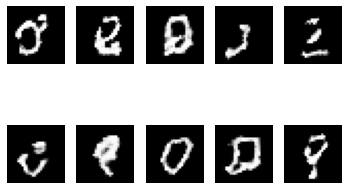

469/469 [==============================] - 34s 73ms/step - d_loss: -17.7676 - g_loss: -412.1631
Epoch 12/101
469/469 [==============================] - 34s 72ms/step - d_loss: -19.5244 - g_loss: -440.9968
Epoch 13/101
469/469 [==============================] - 34s 72ms/step - d_loss: -19.1374 - g_loss: -468.0224
Epoch 14/101
469/469 [==============================] - 34s 73ms/step - d_loss: -21.4107 - g_loss: -477.1533
Epoch 15/101
469/469 [==============================] - 34s 73ms/step - d_loss: -21.4474 - g_loss: -475.0779
Epoch 16/101
469/469 [==============================] - 34s 72ms/step - d_loss: -19.0737 - g_loss: -480.8366
Epoch 17/101
469/469 [==============================] - 34s 73ms/step - d_loss: -19.0484 - g_loss: -481.5499
Epoch 18/101
469/469 [==============================] - 34s 72ms/step - d_loss: -17.4031 - g_loss: -482.1127
Epoch 19/101
469/469 [==============================] - 34s 72ms/step - d_loss: -17.1352 - g_loss: -459.8302
Epoch 20/101
469/469 [==========

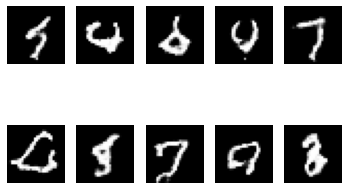

469/469 [==============================] - 34s 72ms/step - d_loss: -12.3580 - g_loss: -429.2981
Epoch 22/101
469/469 [==============================] - 34s 73ms/step - d_loss: -10.2485 - g_loss: -406.2580
Epoch 23/101
469/469 [==============================] - 34s 73ms/step - d_loss: -9.7805 - g_loss: -394.5370
Epoch 24/101
469/469 [==============================] - 34s 72ms/step - d_loss: -8.8962 - g_loss: -380.2719
Epoch 25/101
469/469 [==============================] - 34s 73ms/step - d_loss: -7.0044 - g_loss: -376.2097
Epoch 26/101
469/469 [==============================] - 35s 74ms/step - d_loss: -6.0997 - g_loss: -367.1694
Epoch 27/101
469/469 [==============================] - 34s 72ms/step - d_loss: -4.4110 - g_loss: -353.4226
Epoch 28/101
469/469 [==============================] - 34s 72ms/step - d_loss: -4.7132 - g_loss: -336.0710
Epoch 29/101
469/469 [==============================] - 34s 73ms/step - d_loss: -4.0822 - g_loss: -324.8439
Epoch 30/101
469/469 [=================

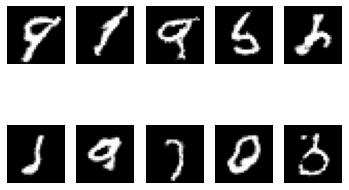

469/469 [==============================] - 35s 74ms/step - d_loss: -2.7496 - g_loss: -316.8821
Epoch 32/101
469/469 [==============================] - 34s 73ms/step - d_loss: -2.4030 - g_loss: -319.5091
Epoch 33/101
469/469 [==============================] - 34s 72ms/step - d_loss: -1.3159 - g_loss: -317.8950
Epoch 34/101
469/469 [==============================] - 34s 72ms/step - d_loss: -1.8614 - g_loss: -307.8986
Epoch 35/101
469/469 [==============================] - 34s 72ms/step - d_loss: -2.2711 - g_loss: -300.8471
Epoch 36/101
469/469 [==============================] - 34s 72ms/step - d_loss: -1.7090 - g_loss: -288.9696
Epoch 37/101
469/469 [==============================] - 34s 72ms/step - d_loss: -1.3202 - g_loss: -279.7005
Epoch 38/101
469/469 [==============================] - 34s 72ms/step - d_loss: -1.2500 - g_loss: -274.6492
Epoch 39/101
469/469 [==============================] - 33s 71ms/step - d_loss: -1.6702 - g_loss: -270.5445
Epoch 40/101
469/469 [===================

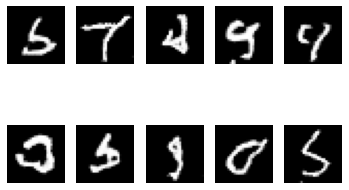

469/469 [==============================] - 34s 72ms/step - d_loss: -1.1988 - g_loss: -259.5341
Epoch 42/101
469/469 [==============================] - 34s 72ms/step - d_loss: -1.1913 - g_loss: -253.7244
Epoch 43/101
469/469 [==============================] - 34s 72ms/step - d_loss: -1.7116 - g_loss: -252.6265
Epoch 44/101
469/469 [==============================] - 34s 72ms/step - d_loss: -1.5042 - g_loss: -241.0571
Epoch 45/101
469/469 [==============================] - 34s 72ms/step - d_loss: -0.8252 - g_loss: -236.2746
Epoch 46/101
469/469 [==============================] - 34s 72ms/step - d_loss: -0.8520 - g_loss: -225.3398
Epoch 47/101
469/469 [==============================] - 34s 72ms/step - d_loss: -0.2645 - g_loss: -223.8408
Epoch 48/101
469/469 [==============================] - 34s 72ms/step - d_loss: -0.8891 - g_loss: -219.0954
Epoch 49/101
469/469 [==============================] - 34s 72ms/step - d_loss: -0.2171 - g_loss: -216.8689
Epoch 50/101
469/469 [===================

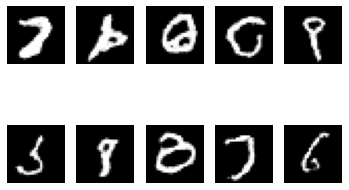

469/469 [==============================] - 34s 72ms/step - d_loss: -0.0483 - g_loss: -207.9619
Epoch 52/101
469/469 [==============================] - 34s 72ms/step - d_loss: -0.3193 - g_loss: -203.5641
Epoch 53/101
469/469 [==============================] - 34s 72ms/step - d_loss: -0.3211 - g_loss: -197.6705
Epoch 54/101
469/469 [==============================] - 34s 72ms/step - d_loss: -0.4553 - g_loss: -188.9892
Epoch 55/101
469/469 [==============================] - 34s 72ms/step - d_loss: -0.2044 - g_loss: -179.8772
Epoch 56/101
469/469 [==============================] - 34s 72ms/step - d_loss: -0.4914 - g_loss: -175.8445
Epoch 57/101
469/469 [==============================] - 34s 72ms/step - d_loss: -0.3881 - g_loss: -173.9169
Epoch 58/101
469/469 [==============================] - 34s 72ms/step - d_loss: 0.1228 - g_loss: -169.5878
Epoch 59/101
469/469 [==============================] - 34s 72ms/step - d_loss: 0.0480 - g_loss: -163.0375
Epoch 60/101
469/469 [=====================

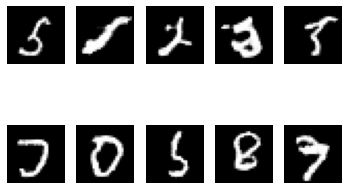

469/469 [==============================] - 34s 72ms/step - d_loss: 0.1888 - g_loss: -171.1698
Epoch 62/101
469/469 [==============================] - 34s 72ms/step - d_loss: -0.2158 - g_loss: -167.0431
Epoch 63/101
469/469 [==============================] - 34s 71ms/step - d_loss: 0.1881 - g_loss: -158.5424
Epoch 64/101
469/469 [==============================] - 34s 72ms/step - d_loss: -0.1488 - g_loss: -159.3014
Epoch 65/101
469/469 [==============================] - 34s 72ms/step - d_loss: 0.3791 - g_loss: -157.0521
Epoch 66/101
469/469 [==============================] - 34s 72ms/step - d_loss: -0.2318 - g_loss: -154.2915
Epoch 67/101
469/469 [==============================] - 34s 73ms/step - d_loss: -0.0770 - g_loss: -155.8286
Epoch 68/101
469/469 [==============================] - 34s 72ms/step - d_loss: 0.1384 - g_loss: -159.7773
Epoch 69/101
469/469 [==============================] - 34s 73ms/step - d_loss: 0.2349 - g_loss: -158.9774
Epoch 70/101
469/469 [========================

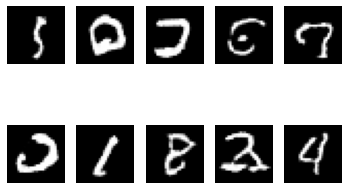

469/469 [==============================] - 34s 73ms/step - d_loss: 0.5144 - g_loss: -158.5349
Epoch 72/101
469/469 [==============================] - 34s 73ms/step - d_loss: -0.2310 - g_loss: -156.9305
Epoch 73/101
469/469 [==============================] - 34s 73ms/step - d_loss: -0.0444 - g_loss: -158.1830
Epoch 74/101
469/469 [==============================] - 34s 72ms/step - d_loss: 0.0458 - g_loss: -161.5234
Epoch 75/101
469/469 [==============================] - 34s 72ms/step - d_loss: 0.2708 - g_loss: -161.1661
Epoch 76/101
469/469 [==============================] - 34s 72ms/step - d_loss: -0.1401 - g_loss: -164.8705
Epoch 77/101
469/469 [==============================] - 34s 72ms/step - d_loss: -0.2173 - g_loss: -164.9564
Epoch 78/101
469/469 [==============================] - 34s 72ms/step - d_loss: 0.0681 - g_loss: -171.3199
Epoch 79/101
469/469 [==============================] - 34s 72ms/step - d_loss: 0.2523 - g_loss: -168.1754
Epoch 80/101
469/469 [========================

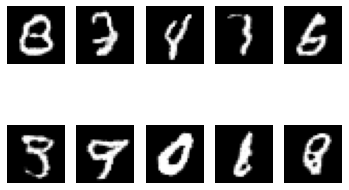

469/469 [==============================] - 34s 73ms/step - d_loss: -0.0605 - g_loss: -168.1194
Epoch 82/101
469/469 [==============================] - 34s 72ms/step - d_loss: -0.0177 - g_loss: -168.5103
Epoch 83/101
469/469 [==============================] - 34s 72ms/step - d_loss: 0.4058 - g_loss: -170.5201
Epoch 84/101
469/469 [==============================] - 34s 72ms/step - d_loss: 0.1886 - g_loss: -169.8484
Epoch 85/101
469/469 [==============================] - 34s 72ms/step - d_loss: -0.2390 - g_loss: -170.4440
Epoch 86/101
469/469 [==============================] - 34s 72ms/step - d_loss: 0.0728 - g_loss: -173.7748
Epoch 87/101
469/469 [==============================] - 34s 72ms/step - d_loss: -0.0413 - g_loss: -172.8938
Epoch 88/101
469/469 [==============================] - 34s 72ms/step - d_loss: -0.2249 - g_loss: -169.1176
Epoch 89/101
469/469 [==============================] - 34s 73ms/step - d_loss: -0.3300 - g_loss: -173.0152
Epoch 90/101
469/469 [======================

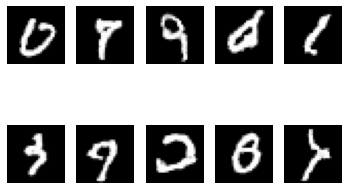

469/469 [==============================] - 34s 72ms/step - d_loss: -0.4507 - g_loss: -176.0055
Epoch 92/101
469/469 [==============================] - 34s 72ms/step - d_loss: 0.1487 - g_loss: -179.8826
Epoch 93/101
469/469 [==============================] - 34s 72ms/step - d_loss: -0.2472 - g_loss: -177.7660
Epoch 94/101
469/469 [==============================] - 34s 72ms/step - d_loss: -0.1754 - g_loss: -178.2135
Epoch 95/101
469/469 [==============================] - 34s 72ms/step - d_loss: -0.3931 - g_loss: -179.7386
Epoch 96/101
469/469 [==============================] - 34s 72ms/step - d_loss: -0.4448 - g_loss: -179.4904
Epoch 97/101
469/469 [==============================] - 34s 72ms/step - d_loss: 0.0087 - g_loss: -180.9850
Epoch 98/101
469/469 [==============================] - 34s 72ms/step - d_loss: -0.4115 - g_loss: -183.7007
Epoch 99/101
469/469 [==============================] - 34s 72ms/step - d_loss: -0.3959 - g_loss: -185.3491
Epoch 100/101
469/469 [====================

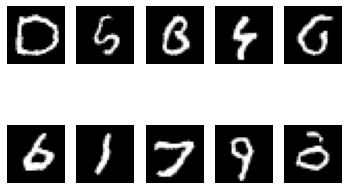

469/469 [==============================] - 34s 73ms/step - d_loss: -0.4263 - g_loss: -190.1672


In [9]:
gan.fit(train_X,
       epochs=101,
       shuffle=True,
       callbacks=[PlotCallback()],
       batch_size=128)